# U-Net Training and Evaluation

In [186]:
import os # To access system files
from IPython.display import display # Utility to easily display images in this environment
# For image manipulation
import PIL 
from PIL import Image, ImageOps
# Required Deep Learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers # To build the U-Net model
from tensorflow.keras.preprocessing.image import load_img # Utility to load images into tensors
# For evaluation metrics
from keras import backend as K
from tensorflow.keras.metrics import MeanIoU
import numpy as np # To transform and manipulate image data
import random # For testing and evaluation
from tensorflow.keras.models import model_from_json # For saving the models to disk

In [185]:
# Importing utils
import Data.DataUtils as DataUtils
from Models.UNet import UNet
from Models.UNetX import UNetX
import Validation.ValidationUtils as Validation

## 1 Data Preprocessing

### 1.1 Loading Image data

In [3]:
input_img_paths, target_img_paths = DataUtils.get_image_paths('./Data/oxford_pets/images/','./Data/oxford_pets/annotations/trimaps/')

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 7390
./Data/oxford_pets/images/Abyssinian_1.jpg | ./Data/oxford_pets/annotations/trimaps/Abyssinian_1.png
./Data/oxford_pets/images/Abyssinian_10.jpg | ./Data/oxford_pets/annotations/trimaps/Abyssinian_10.png
./Data/oxford_pets/images/Abyssinian_100.jpg | ./Data/oxford_pets/annotations/trimaps/Abyssinian_100.png
./Data/oxford_pets/images/Abyssinian_101.jpg | ./Data/oxford_pets/annotations/trimaps/Abyssinian_101.png
./Data/oxford_pets/images/Abyssinian_102.jpg | ./Data/oxford_pets/annotations/trimaps/Abyssinian_102.png
./Data/oxford_pets/images/Abyssinian_103.jpg | ./Data/oxford_pets/annotations/trimaps/Abyssinian_103.png
./Data/oxford_pets/images/Abyssinian_104.jpg | ./Data/oxford_pets/annotations/trimaps/Abyssinian_104.png
./Data/oxford_pets/images/Abyssinian_105.jpg | ./Data/oxford_pets/annotations/trimaps/Abyssinian_105.png
./Data/oxford_pets/images/Abyssinian_106.jpg | ./Data/oxford_pets/annotations/trimaps/Abyssinian_106.png
./Data/oxford_pets/images/Abyssinian_

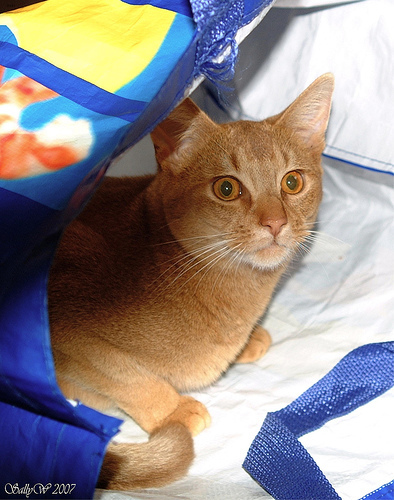

JPEG
(394, 500)
RGB


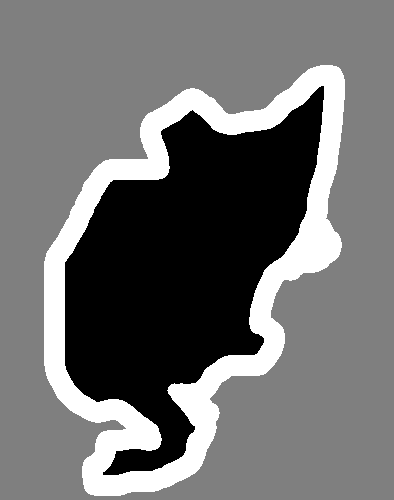

None
(394, 500)
RGB


In [6]:
# Display input image #2
img = PIL.Image.open(input_img_paths[2])
display(img)
print(img.format)
print(img.size)
print(img.mode)

# Display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[2]))
display(img)
print(img.format)
print(img.size)
print(img.mode)

In [44]:
# Finding the minimum image size for training
# * Input images have same dimensions as their masked counterparts
min_width = 9999
min_height = 9999
for input_img_path in input_img_paths:
    img = PIL.Image.open(input_img_path)
    if min_width>img.width:
        min_width = img.width
    if min_height>img.height:
        min_height = img.height
        
print("Minimum width: ", min_width)
print("Minimum height: ", min_height)

Minimum width:  114
Minimum height:  103


### 1.2 Split Data for Training and Validation

In [9]:
def TrainTestSplit(input_img_paths, target_img_paths, split=0.8, r=0):
    random.Random(r).shuffle(input_img_paths)
    random.Random(r).shuffle(target_img_paths)
    train_input_img_paths = input_img_paths[:int(len(input_img_paths)*split)]
    train_target_img_paths = target_img_paths[:int(len(target_img_paths)*split)]
    test_input_img_paths = input_img_paths[-int(len(input_img_paths)*round(1-split,1)):]
    test_target_img_paths = target_img_paths[-int(len(target_img_paths)*round(1-split,1)):]
    return train_input_img_paths, train_target_img_paths, test_input_img_paths, test_target_img_paths

In [10]:
train_input_img_paths, train_target_img_paths, test_input_img_paths, test_target_img_paths = TrainTestSplit(input_img_paths,target_img_paths, split=0.9, r=0)

In [17]:
print(len(train_input_img_paths), len(train_target_img_paths),len(train_input_img_paths)==len(train_target_img_paths))
print(len(test_input_img_paths), len(test_target_img_paths), len(test_input_img_paths)==len(test_target_img_paths))
print(train_input_img_paths[0])
print(train_target_img_paths[0])
print(test_input_img_paths[0])
print(test_target_img_paths[0])

6651 6651 True
739 739 True
./Data/oxford_pets/images/american_pit_bull_terrier_100.jpg
./Data/oxford_pets/annotations/trimaps/american_pit_bull_terrier_100.png
./Data/oxford_pets/images/staffordshire_bull_terrier_34.jpg
./Data/oxford_pets/annotations/trimaps/staffordshire_bull_terrier_34.png


### 1.3 Preprocess Data

In [30]:
train_data = DataUtils.DataHandler(32, (160, 160), train_input_img_paths, train_target_img_paths)
val_data = DataUtils.DataHandler(32, (160, 160), test_input_img_paths, test_target_img_paths)
print("Tensor shape of image data: ", train_data[0][0].shape)
print("Tensor shape of ground truth: ", train_data[0][1].shape)

Tensor shape of image data:  (32, 160, 160, 3)
Tensor shape of ground truth:  (32, 160, 160, 1)


## 2 Training U-Net Models

### 2.1 Defining Models

In [46]:
IMG_WIDTH = 160
IMG_HEIGHT = 160
IMG_CHANNELS = 3
NUM_CLASSES = 3

Unet_model = UNet(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS, NUM_CLASSES).get_model()
UnetX_model = UNetX(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS, NUM_CLASSES).get_model()

In [47]:
Unet_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_2 (Lambda)              (None, 160, 160, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv2d_47 (Conv2D)             (None, 160, 160, 16  448         ['lambda_2[0][0]']               
                                )                                                                 
                                                                                            

 conv2d_61 (Conv2D)             (None, 80, 80, 32)   18464       ['concatenate_10[0][0]']         
                                                                                                  
 dropout_25 (Dropout)           (None, 80, 80, 32)   0           ['conv2d_61[0][0]']              
                                                                                                  
 conv2d_62 (Conv2D)             (None, 80, 80, 32)   9248        ['dropout_25[0][0]']             
                                                                                                  
 conv2d_transpose_19 (Conv2DTra  (None, 160, 160, 16  2064       ['conv2d_62[0][0]']              
 nspose)                        )                                                                 
                                                                                                  
 concatenate_11 (Concatenate)   (None, 160, 160, 32  0           ['conv2d_transpose_19[0][0]',    
          

In [48]:
UnetX_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_66 (Conv2D)             (None, 80, 80, 32)   896         ['input_5[0][0]']                
                                                                                                  
 batch_normalization_15 (BatchN  (None, 80, 80, 32)  128         ['conv2d_66[0][0]']              
 ormalization)                                                                                    
                                                                                            

                                                                  'conv2d_69[0][0]']              
                                                                                                  
 activation_22 (Activation)     (None, 10, 10, 256)  0           ['add_9[0][0]']                  
                                                                                                  
 conv2d_transpose_20 (Conv2DTra  (None, 10, 10, 256)  590080     ['activation_22[0][0]']          
 nspose)                                                                                          
                                                                                                  
 batch_normalization_22 (BatchN  (None, 10, 10, 256)  1024       ['conv2d_transpose_20[0][0]']    
 ormalization)                                                                                    
                                                                                                  
 activatio

 conv2d_transpose_26 (Conv2DTra  (None, 80, 80, 32)  18464       ['activation_28[0][0]']          
 nspose)                                                                                          
                                                                                                  
 batch_normalization_28 (BatchN  (None, 80, 80, 32)  128         ['conv2d_transpose_26[0][0]']    
 ormalization)                                                                                    
                                                                                                  
 activation_29 (Activation)     (None, 80, 80, 32)   0           ['batch_normalization_28[0][0]'] 
                                                                                                  
 conv2d_transpose_27 (Conv2DTra  (None, 80, 80, 32)  9248        ['activation_29[0][0]']          
 nspose)                                                                                          
          

### 2.2 Training Models

Test if GPU is available before training

In [115]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#### 2.2.1 Train U-Net Model

In [51]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
Unet_model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("Checkpoints/unet_segmentation.h5", save_best_only=True, verbose=1),
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='Logs/unet/')
]

# Train the model, doing validation at the end of each epoch.
epochs = 100
#epochs = 15
Unet_model.fit(train_data, epochs=epochs, validation_data=val_data, callbacks=callbacks)

Epoch 1/100
207/207 [==============================] - ETA: 0s - loss: 3.0870
Epoch 1: val_loss improved from inf to 0.74451, saving model to Checkpoints\unet_segmentation.h5
207/207 [==============================] - 39s 149ms/step - loss: 3.0870 - val_loss: 0.7445
Epoch 2/100
207/207 [==============================] - ETA: 0s - loss: 0.6903
Epoch 2: val_loss improved from 0.74451 to 0.62066, saving model to Checkpoints\unet_segmentation.h5
207/207 [==============================] - 31s 150ms/step - loss: 0.6903 - val_loss: 0.6207
Epoch 3/100
207/207 [==============================] - ETA: 0s - loss: 0.5823
Epoch 3: val_loss improved from 0.62066 to 0.53321, saving model to Checkpoints\unet_segmentation.h5
207/207 [==============================] - 30s 147ms/step - loss: 0.5823 - val_loss: 0.5332
Epoch 4/100
207/207 [==============================] - ETA: 0s - loss: 0.5177
Epoch 4: val_loss did not improve from 0.53321
207/207 [==============================] - 30s 147ms/step - loss: 

207/207 [==============================] - 31s 147ms/step - loss: 0.2113 - val_loss: 0.3689
Epoch 36/100
207/207 [==============================] - ETA: 0s - loss: 0.2095
Epoch 36: val_loss did not improve from 0.30581
207/207 [==============================] - 31s 147ms/step - loss: 0.2095 - val_loss: 0.3188
Epoch 37/100
207/207 [==============================] - ETA: 0s - loss: 0.2088
Epoch 37: val_loss improved from 0.30581 to 0.30384, saving model to Checkpoints\unet_segmentation.h5
207/207 [==============================] - 31s 148ms/step - loss: 0.2088 - val_loss: 0.3038
Epoch 38/100
207/207 [==============================] - ETA: 0s - loss: 0.2033
Epoch 38: val_loss improved from 0.30384 to 0.30100, saving model to Checkpoints\unet_segmentation.h5
207/207 [==============================] - 31s 148ms/step - loss: 0.2033 - val_loss: 0.3010
Epoch 39/100
207/207 [==============================] - ETA: 0s - loss: 0.2030
Epoch 39: val_loss did not improve from 0.30100
207/207 [=======

207/207 [==============================] - 31s 152ms/step - loss: 0.1645 - val_loss: 0.3467
Epoch 73/100
207/207 [==============================] - ETA: 0s - loss: 0.1649
Epoch 73: val_loss did not improve from 0.30100
207/207 [==============================] - 31s 151ms/step - loss: 0.1649 - val_loss: 0.3444
Epoch 74/100
207/207 [==============================] - ETA: 0s - loss: 0.1643
Epoch 74: val_loss did not improve from 0.30100
207/207 [==============================] - 32s 155ms/step - loss: 0.1643 - val_loss: 0.3315
Epoch 75/100
207/207 [==============================] - ETA: 0s - loss: 0.1601
Epoch 75: val_loss did not improve from 0.30100
207/207 [==============================] - 31s 150ms/step - loss: 0.1601 - val_loss: 0.3490
Epoch 76/100
207/207 [==============================] - ETA: 0s - loss: 0.1629
Epoch 76: val_loss did not improve from 0.30100
207/207 [==============================] - 31s 148ms/step - loss: 0.1629 - val_loss: 0.3125
Epoch 77/100
207/207 [==========

#### Optional: Save model to JSON

In [58]:
# serialize model to JSON
Unet_json = Unet_model.to_json()
with open("Models/Unet_100.json", "w") as json_file:
    json_file.write(Unet_json)
# serialize weights to HDF5
Unet_model.save_weights("Models/Unet_100.h5")
print("Saved model to disk")

Saved model to disk


#### 2.2.1 Train U-Net XceptionModel

In [59]:
UnetX_model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("Checkpoints/unetx_segmentation.h5", save_best_only=True, verbose=1),
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='Logs/unetx/')
]

# Train the model, doing validation at the end of each epoch.
epochs = 100
#epochs = 15
UnetX_model.fit(train_data, epochs=epochs, validation_data=val_data, callbacks=callbacks)

Epoch 1/100
207/207 [==============================] - ETA: 0s - loss: 0.9622
Epoch 1: val_loss improved from inf to 3.12938, saving model to Checkpoints\unetx_segmentation.h5
207/207 [==============================] - 49s 215ms/step - loss: 0.9622 - val_loss: 3.1294
Epoch 2/100
207/207 [==============================] - ETA: 0s - loss: 0.4960
Epoch 2: val_loss improved from 3.12938 to 1.12924, saving model to Checkpoints\unetx_segmentation.h5
207/207 [==============================] - 45s 217ms/step - loss: 0.4960 - val_loss: 1.1292
Epoch 3/100
207/207 [==============================] - ETA: 0s - loss: 0.4188
Epoch 3: val_loss improved from 1.12924 to 0.44616, saving model to Checkpoints\unetx_segmentation.h5
207/207 [==============================] - 45s 216ms/step - loss: 0.4188 - val_loss: 0.4462
Epoch 4/100
207/207 [==============================] - ETA: 0s - loss: 0.3763
Epoch 4: val_loss improved from 0.44616 to 0.41010, saving model to Checkpoints\unetx_segmentation.h5
207/207 

In [60]:
# serialize model to JSON
UnetX_json = Unet_model.to_json()
with open("Models/UnetX.json", "w") as json_file:
    json_file.write(Unet_json)
# serialize weights to HDF5
UnetX_model.save_weights("Models/UnetX.h5")
print("Saved model to disk")

Saved model to disk


## 3. Model Evaluation

In [125]:
BATCH_SIZE=32
IMG_SIZE = (160,160)
NUM_CLASSES = 3
GROUND_TRUTH = test_target_img_paths[13]
ACTUAL = val_preds[13]

GROUND_TRUTHS = test_target_img_paths
PREDICTIONS = val_preds

In [62]:
# Optional:
# load json and create model
json_file = open('Models/Unet_100.json', 'r')
loaded_Unet_json = json_file.read()
json_file.close()
loaded_Unet = model_from_json(loaded_Unet_json)
# load weights into new model
loaded_Unet.load_weights("Models/Unet_100.h5")
print("Loaded model from disk")

Loaded model from disk


### Helper functions

In [63]:
def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)

In [144]:
""" Helper function to compute IoU scores for one result """
def IoU(GROUND_TRUTH, ACTUAL, BATCH_SIZE, IMG_SIZE):
    # get predicted mask
    mask = np.argmax(ACTUAL, axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    
    # get the ground truth mask into array
    ground_truth = np.zeros((BATCH_SIZE,) + IMG_SIZE + (1,), dtype="uint8")
    truth_mask = load_img(GROUND_TRUTH, target_size=IMG_SIZE, color_mode="grayscale")
    ground_truth = np.expand_dims(truth_mask, 2)
    ground_truth -=1
    
    # compute mean Intersection-Over-Union
    IOU_Keras = MeanIoU(num_classes=3) # Hardcoded for this problem: 3 classes
    IOU_Keras.update_state(ground_truth,mask)
    print("Mean IoU = ", "%.4f" % IOU_Keras.result().numpy())
    
    # print IoU per class (except background)
    values = np.array(IOU_Keras.get_weights()).reshape(3, 3)
    class1_IoU = values[1,1]/(values[1,1] + values[1,2] + values[2,1])
    class2_IoU = values[2,2]/(values[2,2] + values[2,1] + values[1,2])
    print("Class 1 IoU = ", "%.4f" % class1_IoU)
    print("Class 2 IoU = ", "%.4f" % class2_IoU)
    

In [143]:
""" Helper function to compute IoU scores for all results """
def Total_IoU(GROUND_TRUTHS, PREDICTIONS, BATCH_SIZE, IMG_SIZE):
    mean_IoU = []
    average_class1 = []
    average_class2 = []
    
    for i in range(len(PREDICTIONS)):
        # get predicted mask
        mask = np.argmax(PREDICTIONS[i], axis=-1)
        mask = np.expand_dims(mask, axis=-1)

        # get the ground truth mask into array
        ground_truth = np.zeros((BATCH_SIZE,) + IMG_SIZE + (1,), dtype="uint8")
        truth_mask = load_img(GROUND_TRUTHS[i], target_size=IMG_SIZE, color_mode="grayscale")
        ground_truth = np.expand_dims(truth_mask, 2)
        ground_truth -=1

        # compute mean Intersection-Over-Union
        IOU_Keras = MeanIoU(num_classes=3) # Hardcoded for this problem: 3 classes
        IOU_Keras.update_state(ground_truth,mask)
        mean_IoU.append(IOU_Keras.result().numpy())

        # print IoU per class (except background)
        values = np.array(IOU_Keras.get_weights()).reshape(3, 3)
        class1_IoU = values[1,1]/(values[1,1] + values[1,2] + values[2,1])
        class2_IoU = values[2,2]/(values[2,2] + values[2,1] + values[1,2])
        average_class1.append(class1_IoU)
        average_class2.append(class2_IoU)
        
    print("Overall Mean IoU = ", "%.4f" % (sum(mean_IoU)/len(mean_IoU)*100), "%")
    print("Average Class 1 IoU = ", "%.4f" % (sum(average_class1)/len(average_class1)*100), "%")
    print("Average Class 2 IoU = ", "%.4f" % (sum(average_class2)/len(average_class2)*100), "%")


In [187]:
""" Helper function to compute IoU scores for all results """
def Dice_Coef(GROUND_TRUTH, ACTUAL, BATCH_SIZE, IMG_SIZE):
    
    # get predicted mask
    mask = np.argmax(ACTUAL, axis=-1)
    mask = np.expand_dims(mask, axis=-1)

    # get the ground truth mask into array
    ground_truth = np.zeros((BATCH_SIZE,) + IMG_SIZE + (1,), dtype="uint8")
    truth_mask = load_img(GROUND_TRUTH, target_size=IMG_SIZE, color_mode="grayscale")
    ground_truth = np.expand_dims(truth_mask, 2)
    ground_truth -=1
    
    y_true_f = ground_truth.flatten()
    y_pred_f = mask.flatten()
    union = np.sum(y_true_f) + np.sum(y_pred_f)
    if union==0: return 1
    intersection = np.sum(y_true_f * y_pred_f)
    print("Dice Coeficient = ", "%.4f" % (intersection / union*100), "%")

## 3.1 Unet

In [66]:
val_preds = Unet_model.predict(val_data)

23/23 [==============================] - 2s 65ms/step


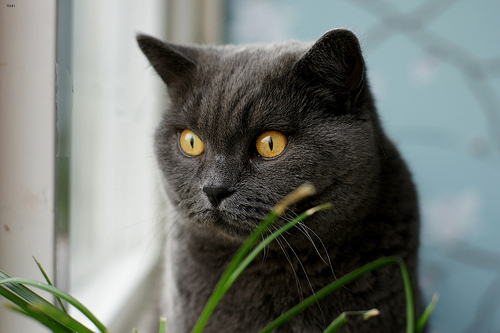

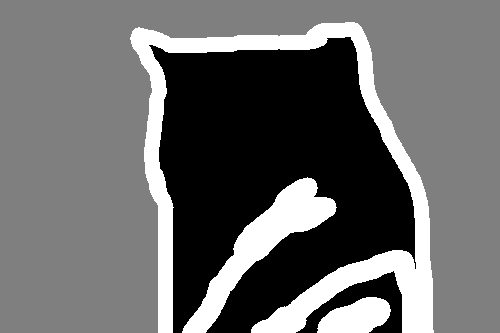

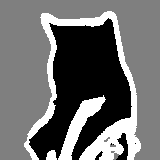

In [69]:
# Display input image
display(Image.open(test_input_img_paths[13]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(test_target_img_paths[13]))
display(img)

# Display mask predicted by our model
display_mask(13)  # Inputs was resized at 160x160.

### Intersection over Union

In [188]:
IoU(GROUND_TRUTH=test_target_img_paths[13], ACTUAL=val_preds[13], BATCH_SIZE=32, IMG_SIZE=(160,160))
Total_IoU(GROUND_TRUTHS=test_target_img_paths, PREDICTIONS=val_pred, BATCH_SIZE=32, IMG_SIZE=(160,160))
Dice_Coef(GROUND_TRUTH=test_target_img_paths[13], ACTUAL=val_preds[13], BATCH_SIZE=32, IMG_SIZE=(160,160))

Mean IoU =  0.7099
Class 1 IoU =  0.9279
Class 2 IoU =  0.6806
Overall Mean IoU =  74.0746 %
Average Class 1 IoU =  92.0817 %
Average Class 2 IoU =  67.8839 %
Dice Coeficient =  57.2581 %


## 3.2 UnetX

In [123]:
val_preds = UnetX_model.predict(val_data)

23/23 [==============================] - 2s 68ms/step


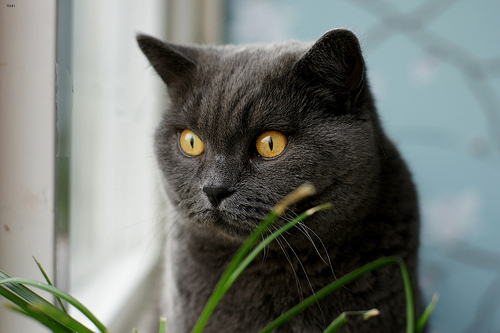

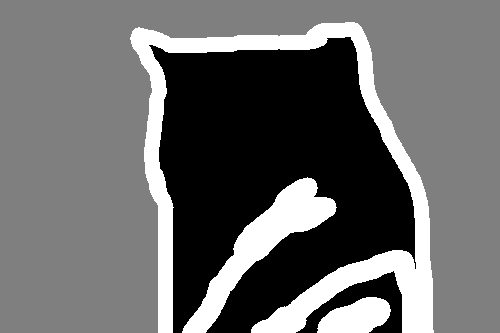

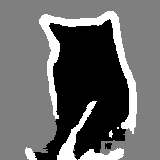

In [128]:
# Display input image
display(Image.open(test_input_img_paths[13]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(test_target_img_paths[13]))
display(img)

# Display mask predicted by our model
display_mask(13)  # Inputs was resized at 160x160.

### Intersection over Union

In [189]:
IoU(GROUND_TRUTH=test_target_img_paths[13], ACTUAL=val_preds[13], BATCH_SIZE=32, IMG_SIZE=(160,160))
Total_IoU(GROUND_TRUTHS=test_target_img_paths, PREDICTIONS=val_pred, BATCH_SIZE=32, IMG_SIZE=(160,160))
Dice_Coef(GROUND_TRUTH=test_target_img_paths[13], ACTUAL=val_preds[13], BATCH_SIZE=32, IMG_SIZE=(160,160))

Mean IoU =  0.7099
Class 1 IoU =  0.9279
Class 2 IoU =  0.6806
Overall Mean IoU =  74.0746 %
Average Class 1 IoU =  92.0817 %
Average Class 2 IoU =  67.8839 %
Dice Coeficient =  57.2581 %
